The fundamental idea for time series analysis is to decompose the original time series (sales, stock market trends, etc.) into several independent components. Typically, business time series are divided into the following four components:

**Trend** – overall direction of the series i.e. upwards, downwards etc.

**Seasonality** – monthly or quarterly patterns

**Cycle** – long-term business cycles, they usually come after 5 or 7 years

**Irregular remainder** – random noise left after extraction of all the components
Interference of these components produces the final series.


# Problem Statement:
PowerHorse, a tractor and farm equipment manufacturing company, was established a few years after World War II. The company has shown a consistent growth in its revenue from tractor sales since its inception. However, over the years the company has struggled to keep it’s inventory and production cost down because of variability in sales and tractor demand. The management at PowerHorse is under enormous pressure from the shareholders and board to reduce the production cost. Additionally, they are also interested in understanding the impact of their marketing and farmer connect efforts towards overall sales. In the same effort, they have hired us as a data science and predictive analytics consultant.

In [2]:
import numpy as np
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [3]:
sales=pd.read_csv("Tractor-Sales.csv")
sales.rename(columns={'Number of Tractor Sold':'Sale'},inplace=True)
sales=pd.DataFrame(sales.iloc[:,1])
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales))
sales['Date']=dates
sales.set_index("Date",inplace=True)

In [4]:
sales.head()

,Sale
Date,
2003-01-01,141
2003-02-01,157
2003-03-01,185
2003-04-01,199
2003-05-01,203


/home/himank/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


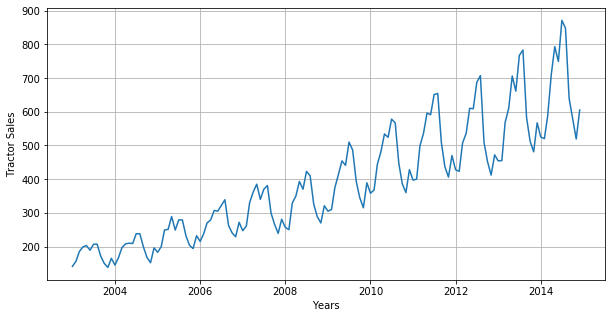

In [5]:
sales_ts=sales['Sale']
plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')
plt.grid()

# Checking Stationarity

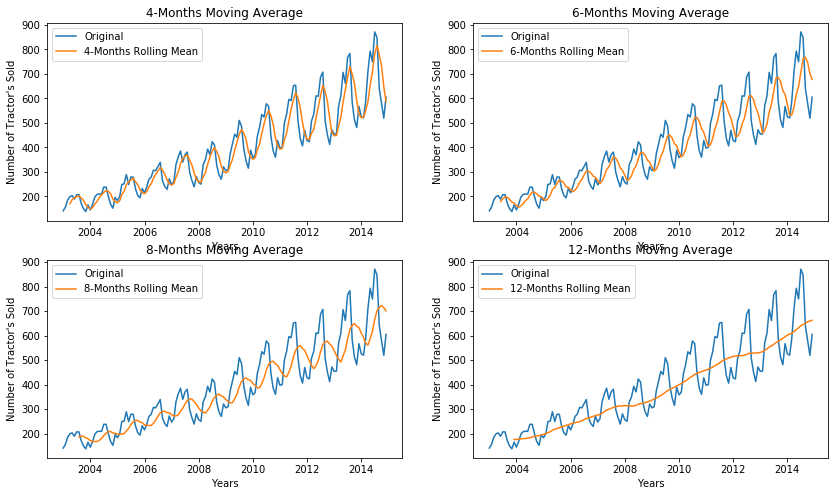

In [6]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.show()

As we could see in the above plots, 12-month moving average could produce a wrinkle free curve as desired. This on some level is expected since we are using month-wise data for our analysis and there is expected monthly-seasonal effect in our data.

Let's plot the rolling mean and standard deviation on window of 12 months.

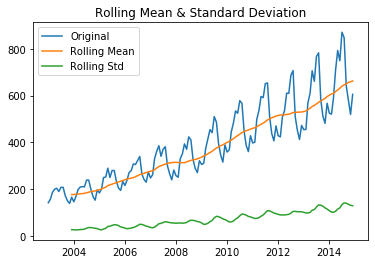

In [7]:
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(sales_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

**Dickey-Fuller Test** - Let's run the Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [8]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


Therefore, The sales time series is non-stationary

# Sesonality:

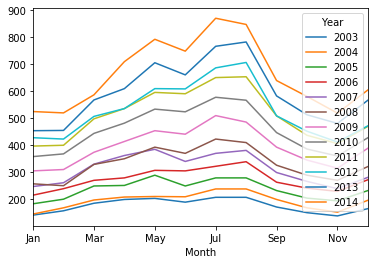

In [9]:
m=dates.month.copy()
m=[i for i in map(lambda x: calendar.month_abbr[x],m)]
y=dates.year.copy()
sales['Month']=m
sales['Year']=y
monthly_sales=sales.pivot_table(values='Sale',index='Month',columns='Year')
monthly_sales=monthly_sales.reindex(index=m[:12])

monthly_sales.plot()


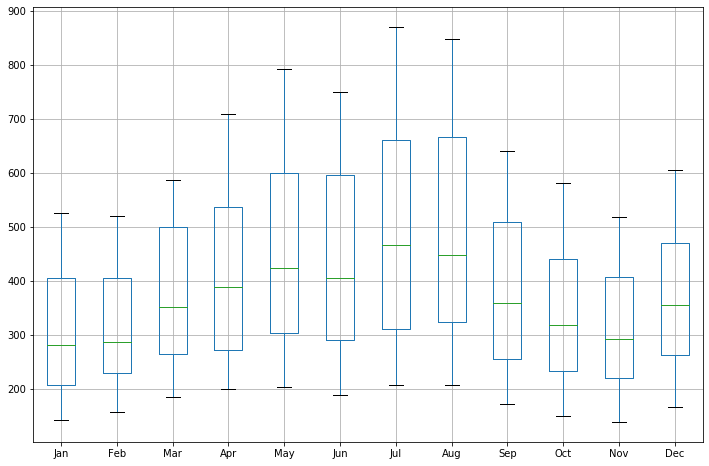

In [10]:
yearly_sales=sales.pivot_table(values='Sale',columns='Month',index="Year")
yearly_sales = yearly_sales[m[:12]]
plt.figure(figsize=(12,8))
yearly_sales.boxplot()

* The tractor sales have been increasing every Year.
* Sales are more in July & August of every Year.
* A sesonal cycle of 12 months.

# Decomposition

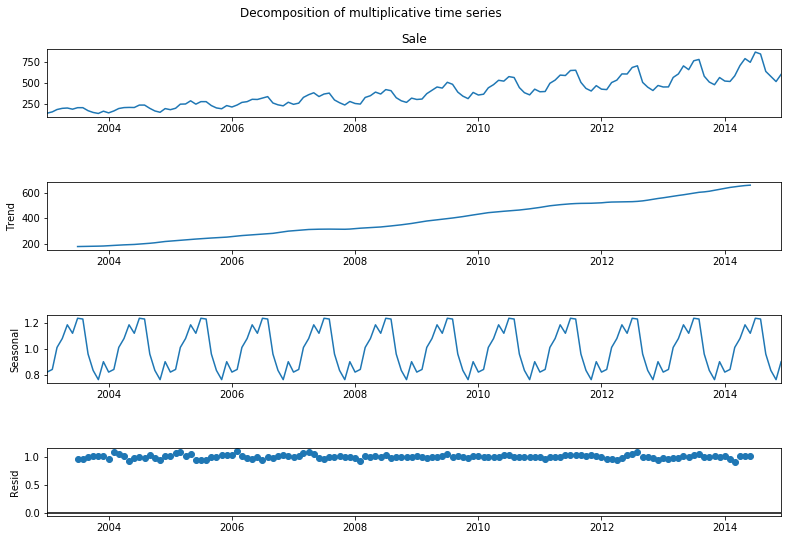

In [11]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
decomposition = smt.seasonal_decompose(sales_ts, model='multiplicative')
fig = decomposition.plot()
plt.tight_layout()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()


* **Trend**: 12-months moving average looks quite similar to a straight line hence we could have easily used linear regression to estimate the trend in this data.
* **Sesonality**: Seasonal plot displays a fairly consistent monthly. The monthly seasonal components are average values for a month after removal of trend. 
* **Irregular Remainder (random)**: is the residual left in the series after removal of trend and seasonal components. Residual should ideally be just white noise without any pattern

# ACF plot:

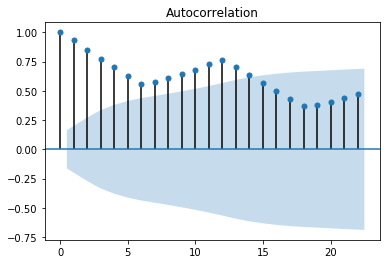

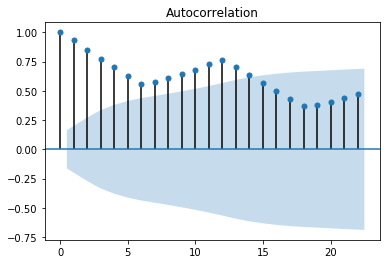

In [12]:
smt.graphics.plot_acf(sales_ts)

# ARMIA:

ARIMA is a combination of 3 parts i.e. AR (AutoRegressive), I (Integrated), and MA (Moving Average). A convenient notation for ARIMA model is ARIMA(p,d,q). Here p,d, and q are the levels for each of the AR, I, and MA partsARIMA is a combination of 3 parts i.e. AR (AutoRegressive), I (Integrated), and MA (Moving Average). A convenient notation for ARIMA model is ARIMA(p,d,q). Here p,d, and q are the levels for each of the AR, I, and MA parts.

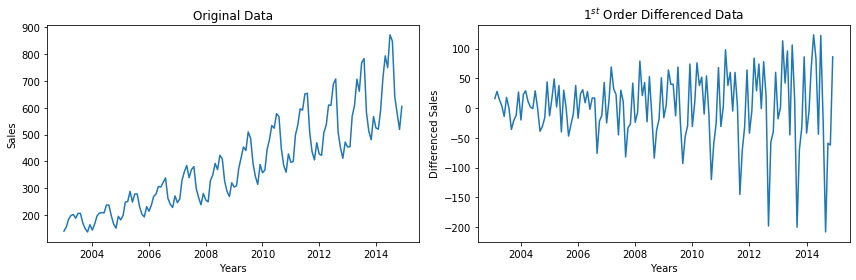

In [13]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
axes[0].plot(sales.index, sales['Sale'])
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Sales")
axes[0].set_title("Original Data")
axes[1].plot(sales.index, sales['Sale'].diff(periods=1))
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Differenced Sales")
axes[1].set_title("1$^{st}$ Order Differenced Data")
plt.tight_layout()
plt.show()

ARIMA(0,1,0) has removed the trend

# Making Variance Constant through Log transformation

Text(0.5, 1.0, 'Constant Variance Time Series')

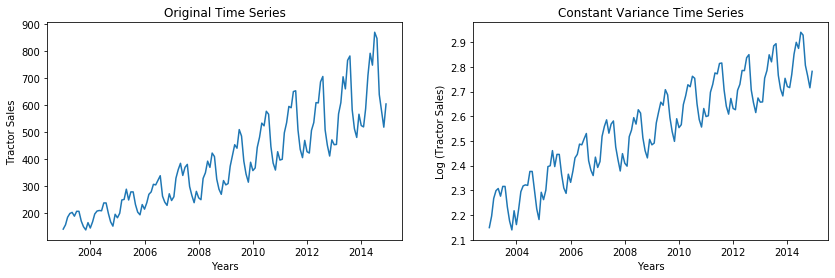

In [14]:
fig,axes=plt.subplots(1,2,sharey=False,sharex=False)
fig.set_figheight(4)
fig.set_figwidth(14)
axes[0].plot(sales_ts)
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Tractor Sales")
axes[0].set_title("Original Time Series")
axes[1].plot(np.log10(sales_ts))
axes[1].set_xlabel('Years')
axes[1].set_ylabel('Log (Tractor Sales)')
axes[1].set_title("Constant Variance Time Series")

## Difference log transform data to make data stationary on both mean and variance

Text(0, 0.5, 'Differenced Log (Tractor Sales)')

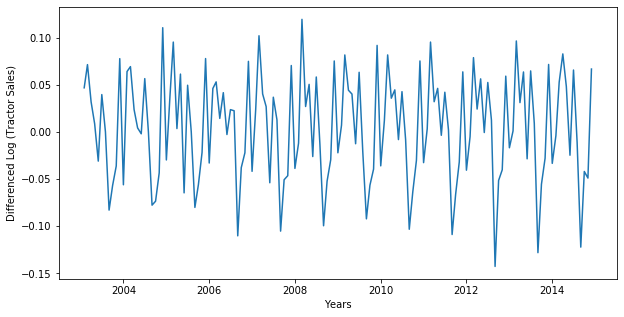

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')

The series is now stationary

## ACF and PACF to identify potential AR and MA model¶

In [53]:
sales_ts_log_diff = np.log10(sales_ts).diff(periods=1)
sales_ts_log_diff.dropna(inplace=True)



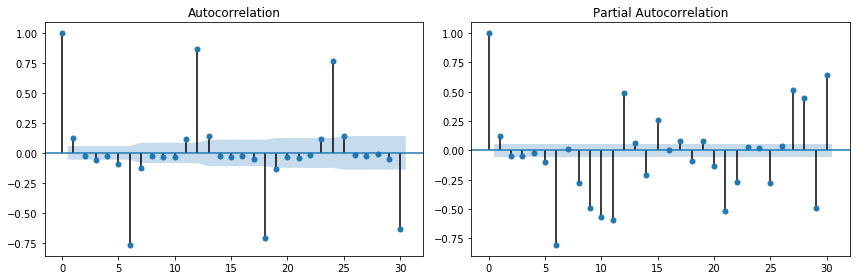

In [54]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()


Since, there are enough spikes in the plots outside the insignificant zone, we can conclude that the residuals are not random. ARIMA model can be used

In [55]:
from pmdarima import auto_arima
sales_ts_log=np.log10(sales_ts)
model = auto_arima(sales_ts_log, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True,information_criterion='aic' ,
                           stepwise=True)
print("best aic: ",model.aic())
print("best order: ",model.order)
print("best seasonal order: ",model.seasonal_order)

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-697.834, BIC=-683.458, Time=3.758 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=-651.889, BIC=-646.138, Time=0.076 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=-692.788, BIC=-681.287, Time=2.713 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-700.790, BIC=-689.289, Time=1.969 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=-653.884, BIC=-651.008, Time=0.133 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=-667.804, BIC=-659.178, Time=0.145 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=-699.211, BIC=-684.835, Time=4.881 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=-698.299, BIC=-683.923, Time=4.189 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=-695.106, BIC=-683.606, Time=2.485 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 2, 12) (constant=True); AIC=-697.315,

In [56]:
order=model.order
seasonal_order=model.seasonal_order

In [57]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(0, 1, 1),
                                      seasonal_order=(0,1,1, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
results=best_model.fit()
print(results.summary().tables[0])
print(results.summary().tables[1])

/home/himank/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/himank/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                               Sale   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 354.393
Date:                            Fri, 21 Feb 2020   AIC                           -702.786
Time:                                    13:08:28   BIC                           -694.160
Sample:                                01-01-2003   HQIC                          -699.281
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4050      0.073     -5.581      0.000      -0.547      -0.263
ma.S.L12      -0.5525      0.096   

/home/himank/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [58]:
pred=results.predict(start=pd.to_datetime('2012-01-01'),end=pd.to_datetime('2014-12-01'),dynamic=True)

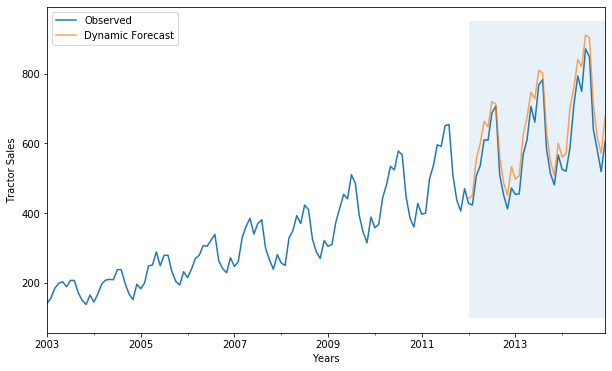

In [59]:
axis = sales_ts.plot(label='Observed', figsize=(10, 6))
np.power(10, pred).plot(ax=axis, label='Dynamic Forecast', alpha=0.7)
axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2012-01-01'), sales_ts.index[-1], alpha=.1, zorder=-1)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()
plt.close()

In [60]:
pred
actual = sales_ts_log['2012-01-01':]

# Compute the mean square error
mse = ((10**pred-10**actual) ** 2).mean()
rmse=np.sqrt(mse)

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 4)))

The Mean Squared Error of our forecasts is 2601.2964
The Root Mean Squared Error of our forecasts is 51.0029


# Forecasting using SARIMA:

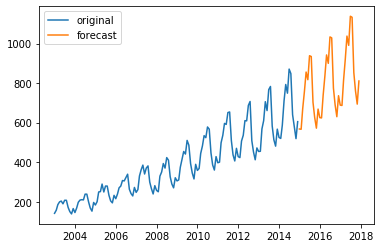

In [65]:
forecast=results.forecast(steps=36)

idx = pd.date_range(sales_ts.index[-1], periods=36, freq='MS')
forecast=10**forecast
plt.plot(sales_ts,label='original')
plt.plot(forecast,label='forecast')
plt.legend()

In [66]:
forecast_95 = results.get_forecast(steps=36, alpha=0.05)
forecast_mean=10**forecast_95.predicted_mean
forecast_ci=10**forecast_95.conf_int()
forecast=forecast_ci.copy()
forecast['sale']=forecast_mean
forecast.head()

,lower Sale,upper Sale,sale
2015-01-01,528.462618,609.999599,567.769306
2015-02-01,521.105279,615.795591,566.475359
2015-03-01,610.766780,736.742512,670.803885
2015-04-01,684.629576,841.276143,758.921952
2015-05-01,765.638827,956.938314,855.960938


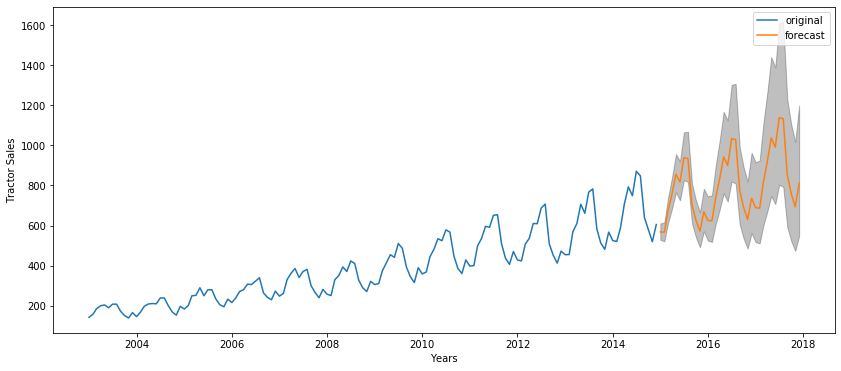

In [67]:
idx = pd.date_range(sales_ts.index[-1], periods=36, freq='MS')
plt.figure(figsize=(14,6))
plt.plot(sales_ts,label='original')
plt.plot(forecast['sale'],label='forecast')
plt.fill_between(forecast.index,forecast['lower Sale'],forecast['upper Sale'],color='k',alpha=0.25)
plt.legend()
plt.xlabel('Years')
plt.ylabel('Tractor Sales');

## ACF and PACF for residuals of ARIMA model to ensure no more information is left for extraction

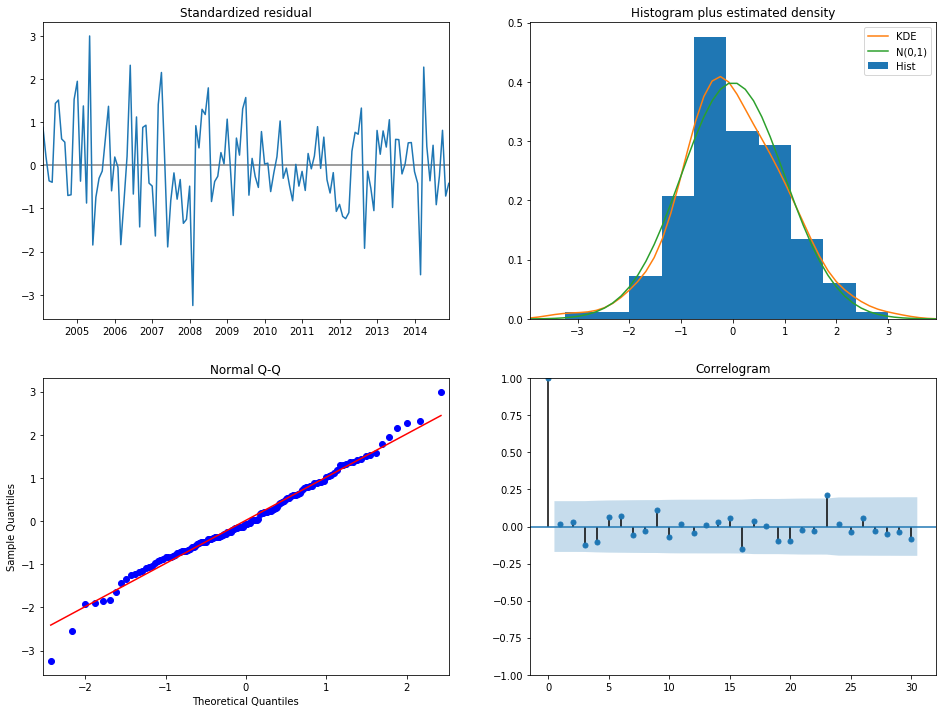

In [69]:
results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If it is not that it signifies that the model can be further improved and we repeat the process with the residuals.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

* The KDE plot of the residuals on the top right is almost similar with the normal distribution.

* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

# Exponential Smoothing

In [74]:
train=sales_ts[:'2012']
test=sales_ts['2013':]


## Single Exponential Smoothing:

In [75]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt


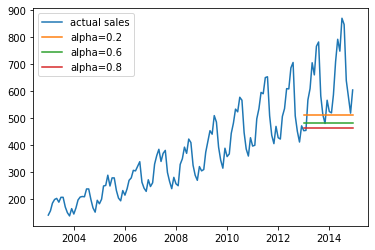

In [105]:
model=SimpleExpSmoothing(train)

fit1=model.fit(smoothing_level=0.2)
forecast1=fit1.forecast(steps=24)

fit2=model.fit(smoothing_level=0.4)
forecast2=fit2.forecast(steps=24)

fit3=model.fit(smoothing_level=0.8)
forecast3=fit3.forecast(steps=24)


plt.plot(sales_ts,label='actual sales')
plt.plot(forecast1,label='alpha=0.2')
plt.plot(forecast2,label='alpha=0.6')
plt.plot(forecast3,label='alpha=0.8')
plt.legend()

## Double Expnential Smoothing (Holt):

/home/himank/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


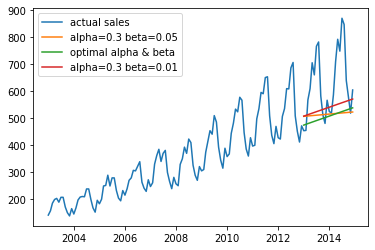

In [111]:
model=Holt(train)

fit1=model.fit(smoothing_level=0.3,smoothing_slope=0.05)
forecast1=fit1.forecast(steps=24)

fit2=model.fit(optimized=True)
forecast2=fit2.forecast(steps=24)

fit3=model.fit(smoothing_level=0.3,smoothing_slope=0.01)
forecast3=fit3.forecast(steps=24)


plt.plot(sales_ts,label='actual sales')
plt.plot(forecast1,label='alpha=0.3 beta=0.05')
plt.plot(forecast2,label='optimal alpha & beta')
plt.plot(forecast3,label='alpha=0.3 beta=0.01')
plt.legend()

## Holt Winter:

In [123]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()
pred = fit.forecast(24)


/home/himank/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/himank/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


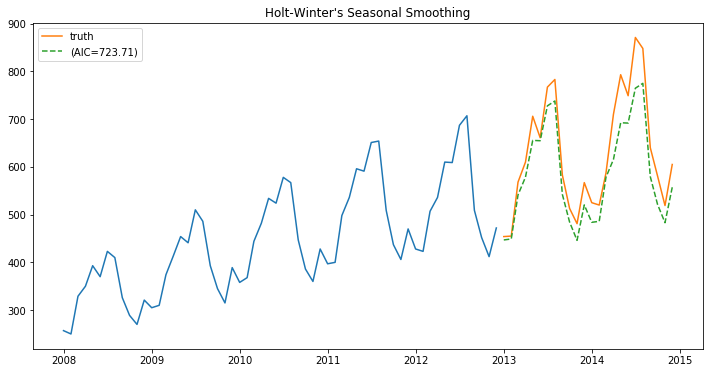

In [124]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', label="(AIC={:0.2f})".format(fit.aic));

ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");
